# Project 3: Wrangling OpenStreeMap Data with SQL

## Auditing Data
First I want to get a sense for what kind of tags I have in my data and the data that falls under those tags. The function count_tags(), counts the number of different values for each attribute key in the data. The group_attrib() function adds all possible data for each attribute as a set() to a dictionary of attributes. It returns the set of values for a particular field passed in as a parameter. 

In [2]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re

tree = ET.parse("Davis2.xml")  #parses XML into an element tree
root = tree.getroot()   #sets root of the tree

def count_tags():
    data_attrib_keys = defaultdict(int)
    for elem in root.iter('tag'):
        data_attrib_keys[elem.attrib['k']] += 1
    return data_attrib_keys

def group_attrib(field):
    attrib_types = defaultdict(set)
    for elem in root.iter('tag'):
        attrib_types[elem.attrib['k']].add(elem.attrib['v'])
    return attrib_types[field]

all_tags = count_tags()

## Phone number formatting:
First, I am going to take a look at the phone numbers, because I suspect the format might be off. 

In [178]:
group_attrib('phone')

{'(530) 753-2040',
 '(530) 753-4900',
 '(530) 753-5007',
 '(530) 753-9664',
 '(530) 754-1111',
 '(530) 756-3540',
 '(530) 756-5212',
 '(530) 756-6440',
 '(530) 758-2251',
 '(530) 758-2855',
 '(530) 758-3223',
 '(530)747-0123',
 '(530)750-7870',
 '(530)759-8888',
 '(800)777-0133',
 '(916) 266-7660',
 '(916) 333-5710',
 '(916) 419-2116',
 '(916) 419-2606',
 '(916) 426-6008',
 '(916) 441-0011',
 '(916) 441-2242',
 '(916) 441-4407',
 '(916) 443-1711',
 '(916) 443-6905',
 '(916) 443-8741',
 '(916) 444-3286',
 '(916) 444-7187',
 '(916) 445-7387',
 '(916) 447-1855',
 '(916) 447-2453',
 '(916) 447-2891',
 '(916) 447-4745',
 '(916) 448-5841',
 '(916) 448-7545',
 '(916) 454-1350',
 '(916) 487-6772',
 '(916) 497-0888',
 '(916) 515-4899',
 '(916) 637-8970',
 '(916) 808-7000',
 '(916) 920-4680',
 '(916) 930-9586',
 '+1  530-792-7312',
 '+1 (916) 286-5800',
 '+1 (916) 442-1000',
 '+1 (916) 447-3268',
 '+1 (916) 660-2723',
 '+1 530 7927015',
 '+1 530-297-4000',
 '+1 530-297-5150',
 '+1 530-302-3485',

I can see that the phone number format is not consistent, in particular the placement/use of dashes and paranthesis. Also some phone numbers include the area code 1, but most do not. I decided to go with the most frequent format, area code in paranthesis without 1 in front, first 3 digits, a dash, followed by the last 4 digits. For example a valid phone number would be (408) 987-1234. The following code updates the tree to correct format. 

In [190]:
#is_incorrect_format() function checks if the phone number is in the desired, expected format
def is_correct_format(phone):
    if re.match(r'\(\d{3}\) \d{3}-\d{4}', phone):
        return True
    else:
        return False

#edit_format() function extracts the digits from the number and appends ( and - in the correct places
def edit_format(phone):
    digits = filter(str.isdigit, phone).lstrip('1')
    correct_format = '(' + digits[0:3] + ') ' + digits[3:6] + '-' + digits[6:10]
    return correct_format
    
#phone_number_edit() fixes the format of incorrectly formatted phone numbers
def phone_number_edit():
    for elem in root.iter('tag'):
        if (elem.attrib['k'] == "phone" or elem.attrib['k'] == "contact:phone"):
            if not is_correct_format(elem.attrib['v']): # not correct format
                print elem.attrib['v'] + ' was changed to: '
                if len(filter(str.isdigit, elem.attrib['v'])) < 10 :
                    print "Error: " + elem.attrib['v']
                elif ';' in elem.attrib['v']: #this means there is more than one phone number given
                    multiple_phones = elem.attrib['v'].split(';')
                    correct_multiple_phones = map(edit_format, multiple_phones)
                    elem.set("v", '; '.join(correct_multiple_phones))
                else:
                    elem.set("v", edit_format(elem.attrib['v']))    #sets the correct format
                print elem.attrib['v']
                        
phone_number_edit()

() - was changed to: 
Error: () -
() -
yes was changed to: 
Error: yes
yes


Phone numbers are fixed!

## Address format issues:

### "addr:state"
Next, I am going to look at addresses, starting with state. I am going to print out the set of all possible state names in my dataset. I get:

In [181]:
print group_attrib('addr:state')

set(['ca', 'CA', 'California', 'Ca'])


Clearly, the state format in the address is inconsistent. I wish to find out how many addresses use each format. I create a function value_count() that creates a dictionary with the number of times each format is used.

In [182]:
def value_count(value):
    value_count_dict = defaultdict(int)
    for elem in root.iter('tag'):
        if elem.attrib['k'] == value:
            value_count_dict[elem.attrib['v']] += 1
    print value_count_dict

value_count("addr:state") 

defaultdict(<type 'int'>, {'ca': 1, 'CA': 21307, 'California': 6, 'Ca': 2})


I find out that the most dominant format is simply 'CA', as I expected. Now its time to update the two records that don't match the format.

In [183]:
def state_edit():
    for elem in root.iter('tag'):
        if elem.attrib['k'] == "addr:state" and elem.attrib['v'] != "CA":
            print elem.attrib['v'] + ' was changed to: '
            elem.set("v", "CA")
            print elem.attrib['v']
            
state_edit()

California was changed to: 
CA
Ca was changed to: 
CA
California was changed to: 
CA
California was changed to: 
CA
California was changed to: 
CA
California was changed to: 
CA
California was changed to: 
CA
Ca was changed to: 
CA
ca was changed to: 
CA


### "addr:postcode"
Now, the state format is fixed! Next I look at zipcodes:

In [184]:
group_attrib('addr:postcode')

{'85834',
 '94566',
 '95605',
 '95616',
 '95616-5270',
 '95618',
 '95673',
 '95691',
 '95695',
 '95776',
 '95811',
 '95814',
 '95815',
 '95816',
 '95817',
 '95818',
 '95819',
 '95820',
 '95821',
 '95822',
 '95831',
 '95833',
 '95834',
 '95835',
 '95837',
 '95838',
 '96516',
 '96816',
 '98584',
 'CA 95616',
 'CA 95819',
 'CA 95833',
 'CA 95834'}

Again I want to look at the prevelance of each format by using my value_count() function. 

In [185]:
value_count("addr:postcode")

defaultdict(<type 'int'>, {'95838': 1, '95822': 5, '96816': 5, '95833': 22, '95831': 4, '95837': 2, '95834': 24, '95835': 20, '94566': 3, 'CA 95834': 2, 'CA 95819': 1, 'CA 95833': 1, '95605': 5106, '96516': 2, '95691': 14953, '95695': 10, '95821': 1, '95820': 9, '85834': 1, '95616-5270': 3, '95618': 32, '95776': 22, '98584': 1, 'CA 95616': 2, '95616': 495, '95673': 3, '95811': 31, '95814': 64, '95815': 20, '95816': 38, '95817': 22, '95818': 72, '95819': 19})


I can see that there are 5 instances where CA is placed in front of the postal code, which is misleading and incorrect since we have a separate attribute for "addr:state". I can also see that some postcodes include the 4 digit area code to be more precise. Although this creates an unnecessary distinction between '95616' and '95616-5720', I don't think it wise to remove precision, so I will not modify this. The code below removes CA from some area codes:

In [186]:
def correct_postalcode(code):
    return re.match(r'\d{5}',code) or re.match(r'\d{5}-\d{4}',code)

def edit_postcode():
    for elem in root.iter('tag'):
        if elem.attrib['k'] == "addr:postcode" and not correct_postalcode(elem.attrib['v']):
            digits = filter(str.isdigit, elem.attrib['v'])
            print elem.attrib['v'] + ' was changed to: '
            if len(digits) > 5:
                elem.set("v", digits[:6] + '-' + digits[6:])
            else:
                elem.set("v", digits)
            print elem.attrib['v']
            #if there is no state, add a state attribute (?)
            
edit_postcode()  

CA 95819 was changed to: 
95819
CA 95834 was changed to: 
95834
CA 95834 was changed to: 
95834
CA 95616 was changed to: 
95616
CA 95833 was changed to: 
95833
CA 95616 was changed to: 
95616


There are a few further issues I discovered while quering my data further in the project. I come back here to clean them up. 

### Coffee Shop name format clean
Starbucks coffee shop is labeled as "Starbucks" and "Starbucks Coffee", which is inconsistent. Similarly there are two versions for Peet's Coffee shop - "Peet's Coffee & Tea" and "Peets Coffee and Tea"

In [192]:
def edit_coffee_shop():
    for element in root.iter('tag'):
        if element.attrib['k'] == 'name' and 'Starbucks' in element.attrib['v']:
            if element.attrib['v'] != 'Starbucks':
                print element.attrib['v'] + ' was changed to: '
                element.set('v', 'Starbucks')
                print element.attrib['v']
        elif element.attrib['k'] == 'name' and ('Peet' in element.attrib['v'] and 'Coffee' in element.attrib['v']):
            if element.attrib['v'] != "Peet's Coffee & Tea":
                print element.attrib['v'] + ' was changed to: '
                element.set('v', "Peet's Coffee & Tea")
                print element.attrib['v']

edit_coffee_shop()

Now its time to write the final updated tree to a new XML file.

In [166]:
tree.write("Davis_updated.xml")

# Converting XML $\rightarrow$ CSV $\rightarrow$ Database
I will use the provided code along with my own shape_element() function to convert XML to CSV.

In [167]:
import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET
import cerberus
import schema

OSM_PATH = "Davis_updated.xml"
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
SCHEMA = schema.schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    if element.tag == 'node':
        node_attribs = element.attrib
        if 'visible' in node_attribs.keys():
            del node_attribs['visible']
    elif element.tag == 'way':
        way_attribs = element.attrib
        if 'visible' in way_attribs.keys():
            del way_attribs['visible']
        
    i = 0
    for a in element.iter('nd'):
        temp_dict = {}
        temp_dict['id'] = way_attribs['id']
        temp_dict['node_id'] = a.attrib['ref']
        temp_dict['position'] = i
        way_nodes.append(temp_dict)
        i+=1

    for a in element.iter('tag'):
        temp_dict = {}
        temp_dict['id'] = element.attrib['id']
        temp_dict['value'] = a.attrib['v']
        if ':' in a.attrib['k']:
            colon = a.attrib['k'].index(':')
            temp_dict['type'] = a.attrib['k'][:colon]
            temp_dict['key'] = a.attrib['k'][colon+1:]
        else:
            temp_dict['type'] = 'regular'
            temp_dict['key'] = a.attrib['k']               
        tags.append(temp_dict)
    
    if element.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=False)

Now all the data from the XML file is in .csv format. Next I used my terminal to create a database file - davis.db from the .csv files. Now it's time to query the database!

# Querring Data

Now I am going to first create a function that will display my query results in nice tables. I will use Python's prettytable library.

In [168]:
import prettytable

def print_pretty_table(headings_list, rows):
    table = prettytable.PrettyTable(headings_list)
    for row in rows:
        table.add_row(row)
    print table

## Amenities
In my first query I will count the number of different types of amenities in the area.

In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

db = sqlite3.connect("davis.db")
c = db.cursor()

def my_query(query, heading):
    c.execute(query)
    rows = c.fetchall()
    print_pretty_table(heading, rows)
    my_df = pd.DataFrame(rows)
    my_df.columns = heading
    return my_df

In [170]:
QUERY = "SELECT value, COUNT(*) as count FROM node_tags WHERE key == 'amenity' GROUP BY value ORDER BY count DESC"
amenity_count_df = my_query(QUERY, ["value", "count"])

+------------------------+-------+
|         value          | count |
+------------------------+-------+
|       restaurant       |   63  |
|          cafe          |   46  |
|       fast_food        |   38  |
|        toilets         |   30  |
|         school         |   23  |
|          fuel          |   21  |
|         bench          |   19  |
|        parking         |   19  |
|     drinking_water     |   16  |
|    place_of_worship    |   16  |
|     waste_disposal     |   11  |
| bicycle_repair_station |   9   |
|          atm           |   8   |
|       car_rental       |   6   |
|          pub           |   6   |
|    vending_machine     |   6   |
|          bank          |   5   |
|          bbq           |   5   |
|    bicycle_parking     |   5   |
|      fire_station      |   5   |
|        fountain        |   5   |
|        post_box        |   5   |
|          bar           |   4   |
|      bus_station       |   3   |
|        car_wash        |   3   |
|         cinema    

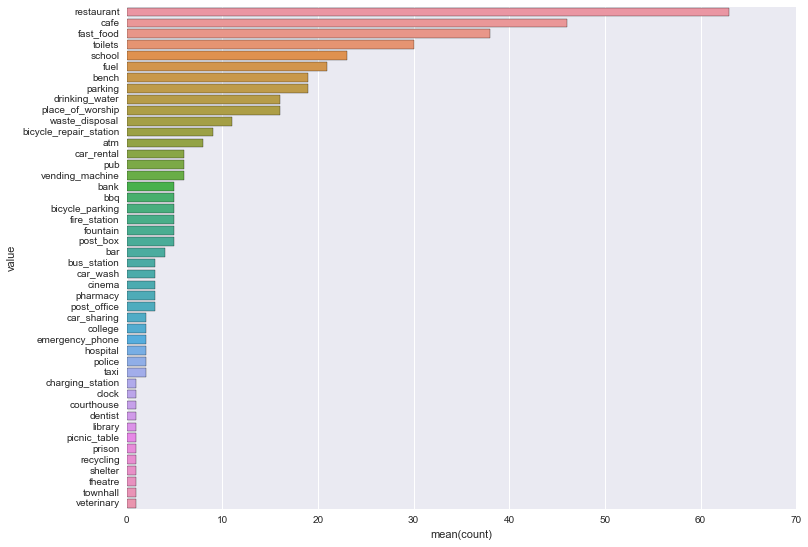

In [171]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
sns.barplot(y="value", x="count", data=amenity_count_df, orient='h')

I can see that restuarants and cafes are most prominent in the area.

# What is the most prominent cuisine?

In [172]:
SUBQUERY = "(SELECT id FROM node_tags WHERE value == 'restaurant')"
QUERY = "SELECT value, COUNT(*) as count FROM node_tags WHERE key == 'cuisine' and id IN" + SUBQUERY + "GROUP BY value ORDER BY count DESC"

cuisine_count_df = my_query(QUERY, ["Cuisine", "count"])

+-------------------+-------+
|      Cuisine      | count |
+-------------------+-------+
|      mexican      |   9   |
|       pizza       |   4   |
|        thai       |   3   |
|       asian       |   2   |
|       burger      |   2   |
|      chinese      |   2   |
|      japanese     |   2   |
|      american     |   1   |
| chinese dumplings |   1   |
|       indian      |   1   |
|   organic;local   |   1   |
|      regional     |   1   |
|      sandwich     |   1   |
|       sushi       |   1   |
+-------------------+-------+


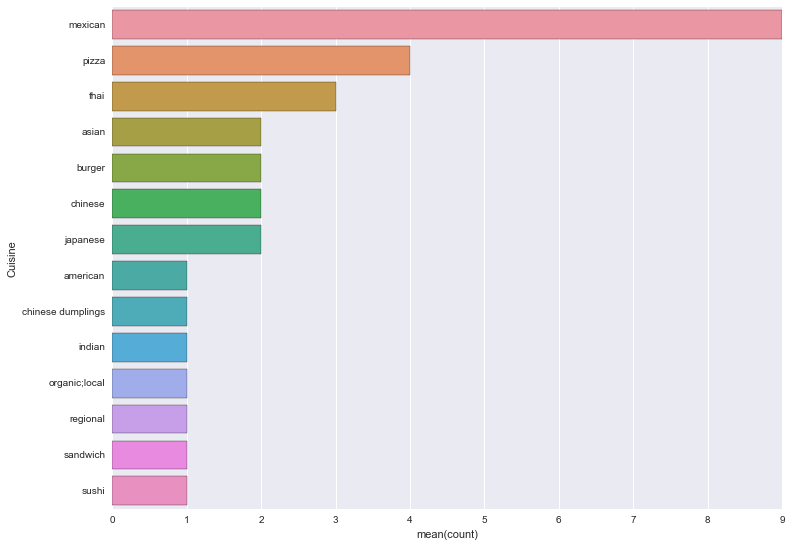

In [173]:
sns.barplot(y="Cuisine", x="count", data=cuisine_count_df, orient='h')

Out of mere curiousity, I decide to print the names of the Mexican restaurants in the area.

In [174]:
SUBQUERY = "(SELECT id FROM node_tags WHERE key = 'cuisine' and value == 'mexican')"
QUERY = "SELECT value as count FROM node_tags WHERE key == 'name' and id IN" + SUBQUERY + "GROUP BY value ORDER BY count DESC"

mexican_resturants_df = my_query(QUERY, ["Mexican Restaurants by Name"])

+-----------------------------+
| Mexican Restaurants by Name |
+-----------------------------+
|     Taqueria Guadalajara    |
|     Taqueria El Burrito     |
|        Taqueria Davis       |
|     La Taqueria Cantina     |
|    La Islites Ostioneria    |
|        El Toro Bravo        |
|          El Pation          |
|         Dos Coyotes         |
|    Chipotle Mexican Grill   |
+-----------------------------+


# How many Starbucks are here?
As a fun query, I'd like to see how many starbucks there are in the area.

In [176]:
SUBQUERY = "(SELECT id FROM node_tags WHERE key = 'cuisine' and value == 'coffee_shop')"
QUERY = "SELECT value, COUNT(*) as count FROM node_tags WHERE key == 'name' and id IN" + SUBQUERY + "GROUP BY value ORDER BY count DESC"

coffee_shop_df = my_query(QUERY, ["Coffee Shop Name", "count"])

+------------------------------+-------+
|       Coffee Shop Name       | count |
+------------------------------+-------+
|          Starbucks           |   5   |
|       Starbucks Coffee       |   3   |
|    Peet's Coffee and Tea     |   2   |
|      Peets Coffee & Tea      |   2   |
|      Barista Brew Cafe       |   1   |
|           Bio Brew           |   1   |
|         Cargo Coffee         |   1   |
|      Cloud Forest Cafe       |   1   |
|        Common Grounds        |   1   |
|    Common Grounds Coffee     |   1   |
|         Mocha Joe's          |   1   |
| Pachamama Coffee Cooperative |   1   |
|        Sodexho Coffee        |   1   |
+------------------------------+-------+


Hence, there are 5 Starbucks coffee shops in the area. 